# Loss and critical point analysis

### Content

- [1. Loss statistics](#1.-Loss-statistics)
- [2. Critical points](#2.-Critical-points)
    - [2.1. Naive visualization](#2.1.-Naive-visualization)
    - [2.2. Angle equivalences](#2.2.-Angle-equivalences)
    - [2.3. Good vs bad critical points](#2.3.-Good-vs-bad-critical-points)
    - [2.4. Dimensionality reduction methods](#2.4.-Dimensionality-reduction-methods)

Like in any ML problem, our optimization algorithm tries to find some weights that define a function that tries to map an input to an output.

In this problem, the input are the rotated angles while the output are the true angles. The function is defined by 6 weights that can be translated into a 4x4 rotation matrix. During the optimization, these 6 weights change. We will show the loss statistics when these weights converge to a value and the trajectories on the weight space of the optimization algorithm. Because this weights translate into a 4x4 rotation matrix, different values can result in similar rotation matrices (for example, adding 2π to any of the 6 weights does not change the resulting rotation matrix).

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [28]:
import sys
sys.path.insert(1,'../')
from oml.angles import rotations_equal

# 1. Loss statistics

Using different initializations is quite important in this case, as the convergence to a good critical point (loss = 0) depends on it. This is due to the highly non-convex nature of the problem, which does not ensure convergence to a global minimum. When trying random uniform initialization from 0 to 2π for each weight, we see convergence only in 63% of the cases (Adam optimizer).

In [37]:
df = pd.read_csv("../results/alignment/loss.csv")  # Generated manually from different initializations
df['seed'] = df.seed.astype(int)
prop_good = (df['final_loss'] < 0.1).mean() * 100
print(f"Initializations with good convergence: {prop_good:.2f} %")

Initializations with good convergence: 63.00 %


Looking at the distribution of loss for the final points, we see that it is quite binary. It converges (loss = 0), or it finds a subset of local minima (loss ~ 1.81).

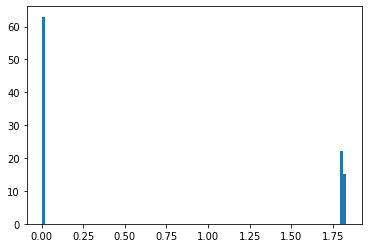

In [4]:
plt.hist(df['final_loss'], bins=100)
plt.show()

We now zoom on both peaks of the histogram:

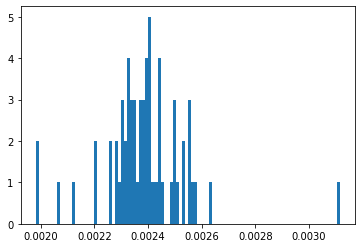

In [5]:
plt.hist(df.loc[df.final_loss < 0.1,'final_loss'], bins=100)
plt.show()

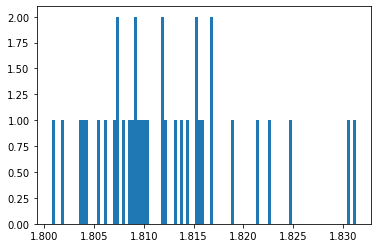

In [6]:
plt.hist(df.loc[df.final_loss > 0.1,'final_loss'], bins=100)
plt.show()

# 2. Critical points

## 2.1. Naive visualization

Let's try to visualize the weights critical points for different starting initializations of the rotation matrix.

In [ ]:
path = '../results/alignment/trajectories/'

In [10]:
end_point = []
for namefile in os.listdir(path):
    file = np.load(path+namefile)
    end_point = np.concatenate((end_point,file[-1,:]))
    
end_point = end_point.reshape(100,6)

Next plot shows the first 3 out of 6 coordinates of the final weights of the optimization convergence trajectories. It does not seem that there is a clear pattern from the points. Some of these points are equivalent to each other (angle relationships).

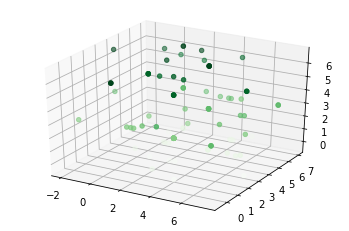

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.scatter3D(end_point[:,0], end_point[:,1], end_point[:,2],c=end_point[:,2],cmap='Greens')

## 2.2. Angle equivalences

To generate the 4x4 rotation matrix (see below function), we take each of the 6 weights and compute first their sine and cosine. Then multiple matrices are generated using these values and then they are multiplied.

In [ ]:
def euler6tomarix4d(a_R):
    """ Convert 6D vector containing angles to 4D rotation matrix

    a_R: tf.tensor/np.ndarray
        Vector of shape (6,)

    Returns
    -------
    R: tf.tensor/np.ndarray
        4x4 Rotation matrix corresponding to these 6 angles of rotations
    """
    xy, xz, xw, yz, yw, zw = a_R

    cxy = np.cos(xy)
    cxz = np.cos(xz)
    cxw = np.cos(xw)
    cyz = np.cos(yz)
    cyw = np.cos(yw)
    czw = np.cos(zw)

    sxy = np.sin(xy)
    sxz = np.sin(xz)
    sxw = np.sin(xw)
    syz = np.sin(yz)
    syw = np.sin(yw)
    szw = np.sin(zw)

    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = np.array([[  cxy,  -sxy, 0.0, 0.0],
              [  sxy,   cxy, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])

    Rxz = np.array([[  cxz, 0.0,  -sxz, 0.0],
               [0.0, 1.0, 0.0, 0.0],
               [  sxz, 0.0,   cxz, 0.0],
               [0.0, 0.0, 0.0, 1.0]])

    Rxw = np.array([[  cxw, 0.0, 0.0,  -sxw],
               [0.0, 1.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 0.0],
               [  sxw, 0.0, 0.0,  cxw]])

    Ryz = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0,   cyz,  -syz, 0.0],
               [0.0,   syz,   cyz, 0.0],
               [0.0, 0.0, 0.0, 1.0]])

    Ryw = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0,   cyw, 0.0,  -syw],
               [0.0, 0.0, 1.0, 0.0],
               [0.0,   syw, 0.0,  cyw]])

    Rzw = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0],
               [0.0, 0.0,   czw,  -szw],
               [0.0, 0.0,   szw,  czw]])

    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    return R

Since the sine and cosine are first computed, we can use certain relationships on each weight:
* Adding 2π does not change the sine nor the cosine
* Adding π changes the sign of both the cosine and the sine
* Changing the sign of the weight changes the sign of the sine
* Changing the sign of the weight and adding π changes the sign of the cosine
When trying different combinations of these transformations for all 6 weights, we see that certain combinations result in identical rotation matrices.

So, we designed a function (see below) that applies each of these invariant combinations and selects the one that minimizes sum(**w**).

In [ ]:
def create_unique_angle(point, ret_full=False):
    """Constructs the equivalent 6d vector with all positive components
    such that their sum is minimum"""
    add_pi = lambda x: x + np.pi
    opp = lambda x: -x
    opp_pi = lambda x: np.pi - x
    idd = lambda x: x
    LIST_FUN = [idd, opp, add_pi, opp_pi]
    LIST_EQUIV = [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 3, 2],
        [0, 0, 2, 0, 3, 2],
        [0, 0, 2, 2, 0, 0],
        [0, 2, 1, 1, 2, 0],
        [0, 2, 1, 3, 1, 2],
        [0, 2, 3, 1, 1, 2],
        [0, 2, 3, 3, 2, 0],
        [2, 1, 1, 1, 1, 2],
        [2, 1, 1, 3, 2, 0],
        [2, 1, 3, 1, 2, 0],
        [2, 1, 3, 3, 1, 2],
        [2, 3, 0, 0, 3, 2],
        [2, 3, 0, 2, 0, 0],
        [2, 3, 2, 0, 0, 0],
        [2, 3, 2, 2, 3, 2]
    ]
    p = [x % (2 * np.pi) for x in point]
    best_sum = np.inf
    best_point = None
    best_eq = None
    diff_1 = np.array(p) - np.array(point)
    diff_2 = np.zeros(6)
    for eq in LIST_EQUIV:
        x = np.zeros_like(p)
        _diff_2 = np.zeros(6)
        for i in range(6):
            x[i] = LIST_FUN[eq[i]](p[i])
            if x[i] < 0:
                x[i] += 2 * np.pi
                _diff_2[i] += 2 * np.pi
            elif x[i] > (2 * np.pi):
                x[i] -= 2 * np.pi
                _diff_2[i] -= 2 * np.pi
        if sum(x) == best_sum:
            # Ties are solved by smaller first components
            for i in range(6):
                if x[i] == best_point[i]:
                    continue
                elif x[i] < best_point[i]:
                    best_point = x
                    best_eq = eq
                    diff_2 = _diff_2.copy()
                    break
                else:
                    break
        elif sum(x) < best_sum:
            best_point = x
            best_sum = sum(x)
            best_eq = eq
            diff_2 = _diff_2.copy()
    if ret_full:
        best_eq = [LIST_FUN[best_eq[i]] for i in range(6)]
        return best_point, best_eq, diff_1, diff_2
    return best_point

To look at other approaches we tried first (like looking at the relationship between the 6 weights and the rotation matrix analitically), please look the *test_rotation_similarity_and_unique_angle.ipynb* notebook

## 2.3. Good vs bad critical points

Let's compile a list for the good critical points and bad critical points and use angle equivalence relations to see if they are the same.

In [39]:
df['good_conv'] = (df['final_loss'] < 0.1)
n_runs = 100
trajectories = {}
critical_points = np.zeros([n_runs, 6])
for i in range(n_runs):
    trajectories[i] = np.load(f'../results/alignment/trajectories/{i}.npy')
    critical_points[i, :] = trajectories[i][-1, :]
df['norm_cp'] = (critical_points**2).sum(1)**(1/2)

In [46]:
seed_order = df.loc[df.good_conv].sort_values('norm_cp').seed.values
unique_good_R = []
for seed in seed_order:
    equal = False
    for r in unique_good_R:
        # Look if points are equivalent (e.g. adding pi to any component does not change the rotation matrix)
        if rotations_equal(r, critical_points[seed, :]):
            equal = True
            break
    if not equal:
        unique_good_R += [critical_points[seed, :]]

When examining all the good solutions (loss = 0), we find that all of them are equivalent (generate the same rotation matrix). So, empirically, there is only one global minimum.

In [47]:
unique_good_R

[array([ 4.3201825 ,  0.55304593,  2.78951382, -0.07910504,  0.58023999,
         0.68084799])]

In [48]:
seed_order = df.loc[~df.good_conv].sort_values('norm_cp').seed.values
unique_bad_R = []
for seed in seed_order:
    equal = False
    for r in unique_bad_R:
        if rotations_equal(r, critical_points[seed, :]):
            equal = True
            break
    if not equal:
        unique_bad_R += [critical_points[seed, :]]

Howewer, when it does not converge to this global minimum, it finds one of multiple local minima (we found 34 different solutions out of the generated 37).

In [50]:
len(unique_bad_R)

34

In [52]:
len(df.loc[~df.good_conv])

37

## 2.4. Dimensionality reduction methods

In this section, we use the unique creation angle method described in 2.2. on each of the critical points (good and bad). Since each point has 6 components, we use different embedding methods (like PCA or Isomap) to look if there is a pattern between the points.

This is a much better approach than the one used at 2.1., as the plots show. Particularly, on Isomap we see that most of the bad points lie in a line, which makes sense since Isomap is best for mapping geodesic distances (which is best when the problem deals with angles).

In [1]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import sys
sys.path.insert(1,'../')
from oml.angles import euler2quaternion
from oml.alignment import loss_alignment

In [ ]:
def show_projection_crit_points(proj):
    _y = y_proj[proj]
    colors = ['navy', 'darkorange']
    for color, i, target_name in zip(colors, [True, False], ['good', 'bad']):
        _yi = _y[df.good_conv == i]
        plt.scatter(_yi[:,0], _yi[:,1], alpha=.3, color=color, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(f'{proj} of critical points')
    plt.show()

In [18]:
df = pd.read_csv("../results/alignment/loss.csv")
df['seed'] = df.seed.astype(int)
df['good_conv'] = (df['final_loss'] < 0.1)

In [19]:
n_runs = 100
trajectories = {}
critical_points = np.zeros([n_runs, 6])
for i in range(n_runs):
    trajectories[i] = np.load(f'../results/alignment/trajectories/{i}.npy')
    critical_points[i, :] = trajectories[i][-1, :]

In [20]:
y = list()
for x in critical_points:
    y.append(create_unique_angle(x))
y = np.array(y)

In [22]:
pca = PCA()
pca.fit(y)
print(pca.explained_variance_ratio_)

[0.66253589 0.22295879 0.05092455 0.04399491 0.01360243 0.00598343]


In [23]:
y_proj = {}
model = PCA(n_components=2)
y_proj['PCA'] = model.fit_transform(y)
model = TSNE(n_components=2)
y_proj['TSNE'] = model.fit_transform(y)
model = MDS(n_components=2)
y_proj['MDS'] = model.fit_transform(y)
model = Isomap(n_components=2)
y_proj['Isomap'] = model.fit_transform(y)

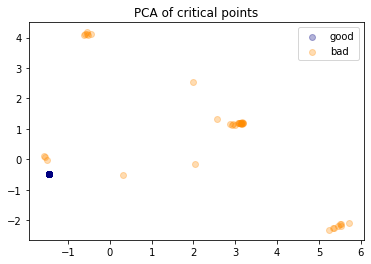

In [24]:
show_projection_crit_points('PCA')

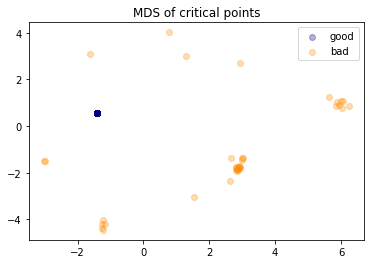

In [25]:
show_projection_crit_points('MDS')

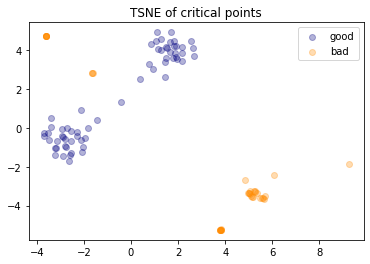

In [26]:
show_projection_crit_points('TSNE')

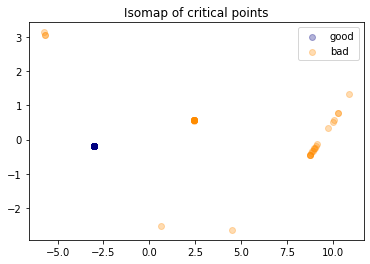

In [27]:
show_projection_crit_points('Isomap')